In [ ]:
# default_exp core

# Core XLA extensions

In [ ]:
#hide
#colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#hide_input
#colab
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
#hide
#colab
!curl -s https://course.fast.ai/setup/colab | bash 

Updating fastai...
Done.


### Setup torch XLA


In [ ]:
#hide_output
#colab
VERSION = "20200325"  #@param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4994  100  4994    0     0  64857      0 --:--:-- --:--:-- --:--:-- 64857
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200325 ...
     |████████████████████████████████| 61kB 2.5MB/s 
Uninstalling torch-1.5.1+cu101:
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12
Done updating TPU runtime
  Successfully uninstalled torch-1.5.1+cu101
Uninstalling torchvision-0.6.1+cu101:
  Successfully uninstalled torchvision-0.6.1+cu101
Copying gs://tpu-pytorch/wheels/torch-nightly+20200325-cp36-cp36m-linux_x86_64.whl...
- [1 files][ 83.4 MiB/ 83.4 MiB]                                                
Operation completed over 1 objects/83.4 MiB.                                     


Install fastai2

In [ ]:
#hide_output
#colab
!pip install fastai2 --upgrade > /dev/null

In [ ]:
#hide
#colab
!pip install nbdev --upgrade > /dev/null

In [ ]:
#hide
#colab
%cd /content/drive/My\ Drive/fastai_xla_extensions

/content/drive/My Drive/fastai_xla_extensions


In [ ]:
#hide
from nbdev.showdoc import *

## Check if XLA is available

In [ ]:
#exporti
import torch
XLA_AVAILABLE = True
try:
    import torch_xla.core.xla_model as xm
except ImportError as e:
    XLA_AVAILABLE = False
    import warnings
    warnings.warn('fastai_xla_extensions requires Pytorch-XLA, will revert to default',
                  RuntimeWarning)

### Fake XLA functionality if XLA not available
if TPU not available, fake xm to call opt.step anyway, 
and fake xla_device to return gpu if available, else return cpu
to ensure compatible behavior in using fastai_xla_extensions as 
normal fastai behavior if TPU not available

In [ ]:
#exporti
if not XLA_AVAILABLE:
    from types import SimpleNamespace
    import torch.cuda
    def fake_opt_step(opt,barrier=False): 
        opt.step()
    def fake_device():
        gpu_available = torch.cuda.is_available() 
        return torch.device(torch.cuda.current_device()) if gpu_available else torch.device('cpu')
    xm = SimpleNamespace(
        optimizer_step = fake_opt_step,
        xla_device = fake_device
    )
    

## XLA Optim Proxy
`XLAOptimProxy` is a class which has overridden the `step` method to call the Pytorch-XLA function `xm.optimizer_step` which synchronizes the XLA graph. All other calls to `XLAOptimProxy` just forward it to the internal `self.opt` instance.

In [ ]:
#export
class XLAOptimProxy:
    def __init__(self,opt):
        self.opt = opt
        
    def xla_step(self):
        xm.optimizer_step(self.opt,barrier=True) # sync on gradient update
        
    def __getattr__(self,name):
        if name == 'step': # override proxying for step method
                return getattr(self,'xla_step')
        # proxy everything else
        return getattr(self.opt,name)    

## XLA OptFunc Wrapper
Wraps the `opt_func` (which is a fastai function that creates an `Optimizer`) with an object that when called returns an `Optimizer` object wrapped around an `XLAOptimProxy`.

In [ ]:
#export
class XLAOptFuncWrapper:
    def __init__(self, f):
        self.f = f 
    def __call__(self, *args, **kwargs):
        opt = self.f(*args, **kwargs)
        optim_proxy = XLAOptimProxy(opt)
        return optim_proxy
    

### Example: Create an MNIST classifier

Import fastai libraries 

In [ ]:
from fastai2.vision.all import *

Load data

In [ ]:
path = untar_data(URLs.MNIST_TINY)
Path.BASE_PATH = path

Create datablock

In [ ]:
datablock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW),CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(),
    item_tfms=Resize(28),
    batch_tfms=[]
)

## Get TPU device

In [ ]:
#colab
tpu = xm.xla_device()

Set dataloader to load the batches to the tpu

In [ ]:
dls = datablock.dataloaders(path, device=tpu)

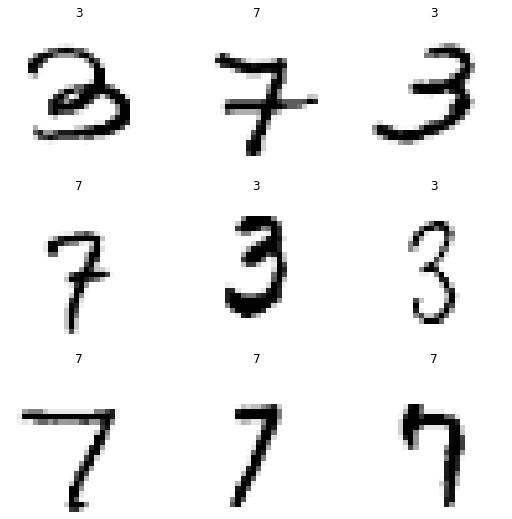

In [ ]:
dls.show_batch()

In [ ]:
xb,yb = dls.one_batch()
(xb.device, xb.shape)

(device(type='xla', index=1), torch.Size([64, 1, 28, 28]))

### Configure OptFunc
Wrap the opt_func with an XLA wrapper so that
the optimizer will call `xm.optimizer_step(opt)` instead of `opt.step` in the step method.

In [ ]:
XLAAdam = XLAOptFuncWrapper(Adam)

In [ ]:
learner = cnn_learner(dls, resnet18, metrics=accuracy, opt_func=XLAAdam)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [ ]:
learner.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.898477,0.235039,0.922747,00:14


epoch,train_loss,valid_loss,accuracy,time
0,0.357270,0.209772,0.912732,00:09


In [ ]:
#hide
#local
%cd ..

In [ ]:
#hide
#ci
!nbdev_clean_nbs

In [ ]:
#hide
#ci
from nbdev.export import *
notebook2script()


In [ ]:
#hide
#ci
!nbdev_build_lib

In [ ]:
#hide
#ci
!nbdev_build_docs